# MNIST Convolutional Neural Network

# Implement a convolutional neural network to recognize hand-written digits



In [ ]:
# # Uncomment the below line and run to install required packages if you have not done so

# !pip install torch torchvision matplotlib tqdm

In [ ]:
# Setup
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm import trange
import numpy as np
import torch.nn as nn


%matplotlib inline
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set random seed for reproducibility
seed = 1234
# cuDNN uses nondeterministic algorithms, set some options for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)

## Get MNIST Data
The `torchvision` package provides a wrapper to download MNIST data. The cell below downloads the training and test datasets and creates dataloaders for each.

In [ ]:
# Initial transform (convert to PyTorch Tensor only)
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.MNIST('data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('data', train=False, download=True, transform=transform)

## Use the following lines to check the basic statistics of this dataset
# Calculate training data mean and standard deviation to apply normalization to data
# train_data.data are of type uint8 (range 0,255) so divide by 255.
train_mean = train_data.data.double().mean() / 255.
train_std = train_data.data.double().std() / 255.
print(f'Train Data: Mean={train_mean}, Std={train_std}')

## Optional: Perform normalization of train and test data using calculated training mean and standard deviation
# This will convert data to be approximately standard normal
#transform = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize((train_mean, ), (train_std, ))
#])

train_data.transform = transform
test_data.transform = transform

batch_size = 64
torch.manual_seed(seed)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=True) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Train Data: Mean=0.1306604762738429, Std=0.30810780717887876


## Inspect dataset

Images shape:  torch.Size([64, 1, 28, 28])
Labels shape:  torch.Size([64])
Mean=0.133231520652771, Std=0.3099796175956726


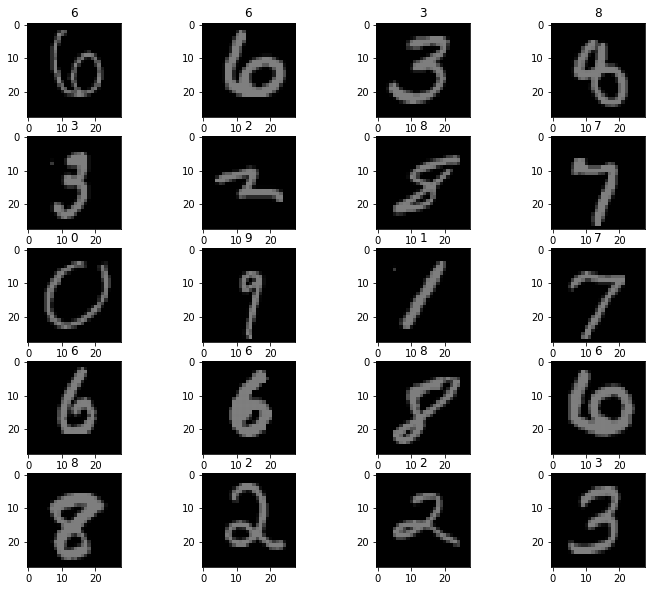

In [ ]:
# Randomly sample 20 images of the training dataset
# To visualize the i-th sample, use the following code
# > plt.subplot(4, 5, i+1)
# > plt.imshow(images[i].squeeze(), cmap='gray', interpolation='none')
# > plt.title(f'Label: {labels[i]}', fontsize=14)
# > plt.axis('off')

images, labels = iter(train_loader).next()

# Print information and statistics of the first batch of images
print("Images shape: ", images.shape)
print("Labels shape: ", labels.shape)
print(f'Mean={images.mean()}, Std={images.std()}')

fig = plt.figure(figsize=(12, 10))
# ------------------
# Copy the implementation from Problem 4 here
# Function to convert tensor to image
def image_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image*np.array((0.5,0.5,0.5))
  return image

for i in np.arange(20):
  ax = fig.add_subplot(5, 4, i + 1)
  plt.imshow(image_convert(images[i]))
  ax.set_title(labels[i].item())
# ------------------

## Implement a convolutional neural network

Write a class that constructs a two-layer neural network as specified in the handout. The class consists of two methods, an initialization that sets up the architecture of the model, and a forward pass function given an input feature.

In [ ]:
input_size = 1 * 28 * 28  # input spatial dimension of images
hidden_size = 128         # width of hidden layer
output_size = 10          # number of output neurons

class CNN(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.flatten = torch.nn.Flatten(start_dim=1)
        # ------------------
        # Write your implementation here.
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=10,            
                kernel_size=5,              
                stride=1,                   
                padding=0,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        ) # first convolutional layer
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=10,              
                out_channels=20,            
                kernel_size=5,              
                stride=1,                   
                padding=0
            ),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        ) # second convolutional layer
        self.fc = nn.Sequential(
            nn.Linear(320, 10),
            nn.ReLU()) # third fully-connected layer
        # ------------------
    
    def forward(self, x):
        # Input image is of shape [batch_size, 1, 28, 28]
        # Need to flatten to [batch_size, 784] before feeding to fc1
        # x = self.flatten(x)

        # ------------------
        # Write your implementation here.
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        y_output = nn.functional.log_softmax(x)
        
        return y_output
        # ------------------

model = CNN().to(DEVICE)

# sanity check
print(model)
from torchsummary import summary
summary(model, (1,28,28))

CNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=320, out_features=10, bias=True)
    (1): ReLU()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
              ReLU-2           [-1, 10, 24, 24]               0
         MaxPool2d-3           [-1, 10, 12, 12]               0
            Conv2d-4             [-1, 20, 8, 8]           5,020
              ReLU-5             [-1, 20, 8, 8]               0
         MaxPool2d-6      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Write a method called `train_one_epoch` that runs one step using the optimizer.

In [ ]:
def train_one_epoch(train_loader, model, device, optimizer, log_interval, epoch):
    model.train()
    losses = []
    counter = []
    
    for i, (img, label) in enumerate(train_loader):
        img, label = img.to(device), label.to(device)

        # ------------------
        # Copy the implementation from Problem 4 here
        # img.reshape(-1, 28*28)

        optimizer.zero_grad()

        output = model(img)

        # criterion = nn.functional.nll_loss()
        loss = nn.functional.nll_loss(output,label)

        # Backpropagation and optimization

        loss.backward()  
        optimizer.step() 
               
        # ------------------
    
        # Record training loss every log_interval and keep counter of total training images seen
        if (i+1) % log_interval == 0:
            losses.append(loss.item())
            counter.append(
                (i * batch_size) + img.size(0) + epoch * len(train_loader.dataset))

    return losses, counter

Write a method called `test_one_epoch` that evalutes the trained model on the test dataset. Return the average test loss and the number of samples that the model predicts correctly.

In [ ]:
def test_one_epoch(test_loader, model, device):
    model.eval()
    test_loss = 0
    num_correct = 0
    
    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            img, label = img.to(device), label.to(device)

            # ------------------
            # Copy the implementation from Problem 4 here

            # img.reshape(-1, 28 * 28)

            output = model(img)

            loss = nn.functional.nll_loss(output, label)

            pred = torch.argmax(output, 1) # Get index of largest log-probability and use that as prediction
            num_correct += torch.sum(pred == label)
            test_loss += loss.item()

            # ------------------
            
    test_loss /= len(test_loader.dataset)
    return test_loss, num_correct

Train the model using the cell below. Hyperparameters are given.

In [ ]:
# Hyperparameters
lr = 0.01
max_epochs=10
gamma = 0.95

# Recording data
log_interval = 100

# Instantiate optimizer (model was created in previous cell)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_losses = []
train_counter = []
test_losses = []
test_correct = []
tt_losses = []
tt_correct = []
for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    train_loss, counter = train_one_epoch(train_loader, model, DEVICE, optimizer, log_interval, epoch)
    test_loss, num_correct = test_one_epoch(test_loader, model, DEVICE)
    train_losss, train_num_correct = test_one_epoch(train_loader, model, DEVICE)

    # Record results
    train_losses.extend(train_loss)
    train_counter.extend(counter)
    test_losses.append(test_loss)
    test_correct.append(num_correct)
    tt_losses.append(train_losss)
    tt_correct.append(train_num_correct)

print(f"Train accuracy: {tt_correct[-1]/len(train_loader.dataset)}")
print(f"Test accuracy: {test_correct[-1]/len(test_loader.dataset)}")
print(f"Test Loss: {test_losses}")
print(f"Train Loss: {tt_losses}")

Epochs: 100%|██████████| 10/10 [06:14<00:00, 37.47s/it]

Train accuracy: 0.5738000273704529
Test accuracy: 0.571399986743927
Test Loss: [0.01603932289481163, 0.015976999896764755, 0.01592783299088478, 0.016071259331703187, 0.015914258497953415, 0.01584193714261055, 0.015864140510559083, 0.015908443784713747, 0.015893859940767287, 0.01580481364130974]
Train Loss: [0.016004324488838515, 0.015931529890497526, 0.015870854288339616, 0.015999683776497842, 0.015858782519896825, 0.015763179752230645, 0.015786406766374907, 0.015815823179483414, 0.015799587440490724, 0.01570835288266341]
